In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima.arima as pm

2022-10-10 00:51:24.993695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 00:51:24.993723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Replace missing values with Zero and Gorup by month

In [2]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Donations', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [3]:
df= pd.read_csv('colheitas.csv', parse_dates=['date'])
df=df.groupby('date').sum()
df=df.resample(rule='M').sum()

In [4]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

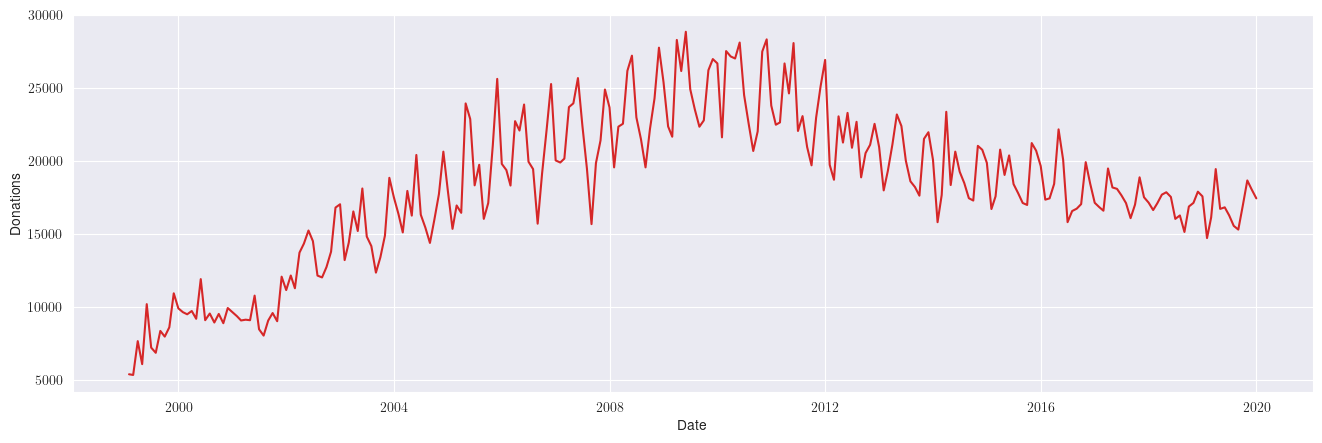

In [5]:
plot_df(df, x=df.index, y=df.nr, title='')

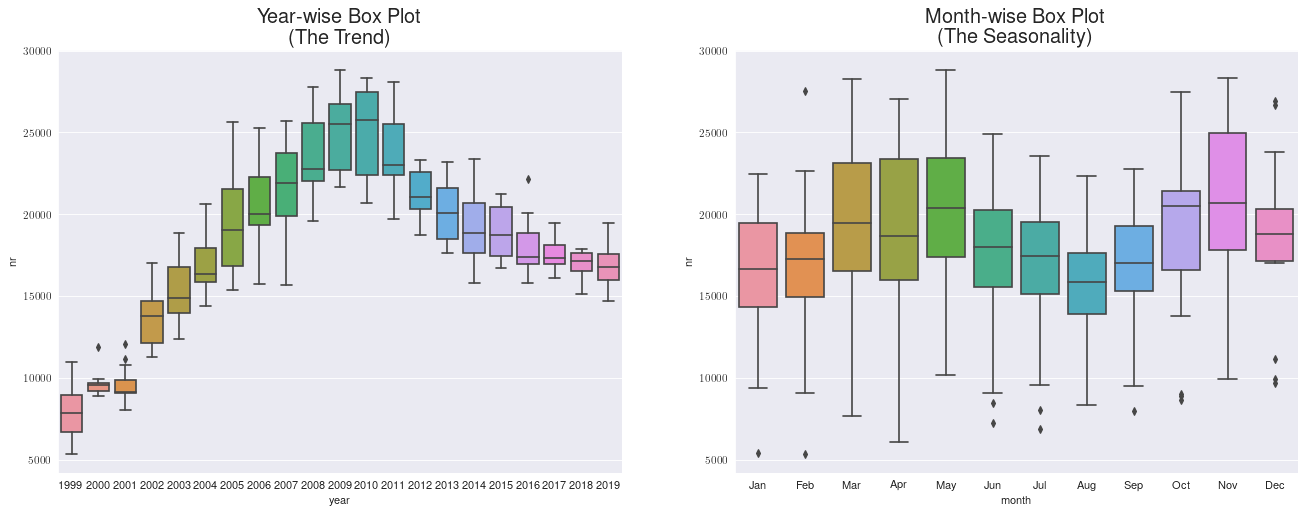

In [6]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='nr', data=df, ax=axes[0])
sns.boxplot(x='month', y='nr', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

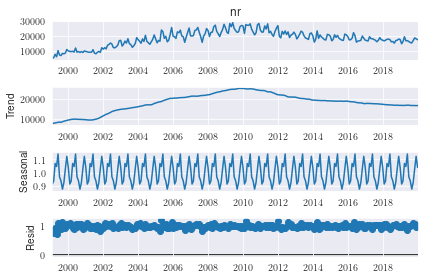

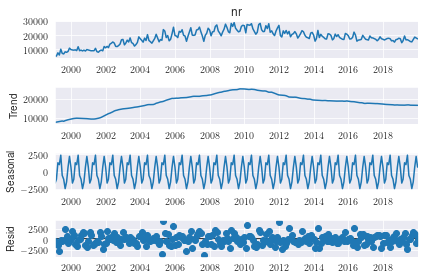

In [7]:
# Multiplicative Decomposition 
seasonal_decompose(df.nr, model='multiplicative', extrapolate_trend='freq').plot();
# Additive Decomposition
seasonal_decompose(df.nr, model='additive', extrapolate_trend='freq').plot();

In [8]:
# ADF Test
result = adfuller(df.nr.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Value s:')
    print(f'   {key}, {value}')

ADF Statistic: -1.8223895482397376
p-value: 0.3694039166817802
Critial Value s:
   1%, -3.4583663275730476
Critial Value s:
   5%, -2.8738660999177132
Critial Value s:
   10%, -2.5733390785693766


In [23]:
#SARIMA optimal parameters
smodel = pm.auto_arima(df[:240].nr, start_p=1, start_q=1,
                         test='adf',
                         max_p=25, max_q=25, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3974.748, Time=3.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4173.893, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4032.419, Time=2.72 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3973.078, Time=2.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4053.774, Time=0.32 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3973.049, Time=3.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3996.585, Time=1.83 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3966.582, Time=5.52 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3964.619, Time=5.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4064.589, Time=1.01 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3966.083, Time=7.07 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC=3966.070, Time=6.21 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4001.356, Time=4.62 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=3967.962, Time=12.31 sec
 ARIMA(0,1,1)(2,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1978.309
Date:                             Mon, 10 Oct 2022   AIC                           3964.619
Time:                                     01:03:27   BIC                           3978.319
Sample:                                          0   HQIC                          3970.147
                                             - 240                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7261      0.045    -16.182      0.000      -0.814      -0.638
ar.S.L12      -0.6586      0.065    -10.179      0.000      -0.785      -0.532
ar.S.L24      -0.3758      0.066     -5.723      0.000      -0.504      -0.247
sigma2      2.126e+06   2.05e+05     10.346      0.000    1.72e+06    2.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                14.94
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.48
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df[239:].index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)

In [53]:
fitted_series

2019-01-01    15798.015803
2019-02-01    15920.275364
2019-03-01    17310.285692
2019-04-01    18400.644027
2019-05-01    17481.121410
2019-06-01    15242.195486
2019-07-01    15457.931573
2019-08-01    14842.344655
2019-09-01    15814.325693
2019-10-01    17505.851511
2019-11-01    16833.143946
2019-12-01    16125.354956
Freq: MS, dtype: float64

In [54]:
collection_pred_sarima = fitted_series
%store collection_pred_sarima

Stored 'collection_pred_sarima' (Series)


In [55]:
actual = df[240:].nr

In [56]:
rmse = sqrt(mean_squared_error(fitted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1160.401


In [57]:
mae = mean_absolute_error(fitted, actual)
print('Test MAE: %.3f' % mae)

Test MAE: 1017.089


In [58]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [59]:
MAPE(fitted, actual)

6.103962987509231